### Using Tree data

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns
from tqdm.notebook import tqdm

dendro = pd.read_feather("data/17766_12.feather")
dendro

,dendroNr,DOY,species,growth
0,HA_001_2012,0,Beech,0.000000
1,HA_001_2012,1,Beech,0.154100
2,HA_001_2012,2,Beech,1.460225
3,HA_001_2012,3,Beech,4.169183
4,HA_001_2012,4,Beech,3.907183
...,...,...,...,...
30805,SH_076_2013,178,Beech,3909.054208
30806,SH_076_2013,179,Beech,3908.649604
30807,SH_076_2013,180,Beech,3908.473708
30808,SH_076_2013,181,Beech,3908.421000


# Fit models

In [94]:
%%capture
# Import my GP
%run ./GP.ipynb

In [95]:
import jaxopt
import jax
import jax.numpy as jnp

dendro_spcs = dendro[dendro.species.eq("Beech")]

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

In [153]:
dendro["deltagrowth"] = np.nan
weibull_params = dict()

for tree in tqdm(dendro.dendroNr.unique()):
    df_ = dendro[dendro.dendroNr.eq(tree)]
    y_ = jnp.array(df_.growth)
    x_ = jnp.array(df_.DOY)

    def f_(params):
        p0, p1, p2 = params
        return jnp.mean((y_ - (p0 * weibull_F(x_, p1, p2))) ** 2) #MSE Loss
        # return jnp.mean(
        #     jax.vmap(jax.tree_util.Partial(jaxopt.loss.huber_loss, delta = 10.))
        #     (y_, p0 * weibull_F(x_, p1, p2)) # Huber Loss
        # )

    solver = jaxopt.ScipyBoundedMinimize(fun = f_)
    res = solver.run(jnp.array([max(y_), 1/(0.632*max(y_)), 3]), jnp.array([(0.1, 0.00001, 1), (100000, 1, 100)]))
    weibull = lambda x__ : res.params[0] * weibull_F(x__.ravel(), res.params[1], res.params[2])

    with np.printoptions(precision=3, suppress=True, threshold=5, floatmode="fixed"):
        print(tree, res.params, res.state.fun_val, res.state.status, res.state.iter_num, sep = '\t')

    dendro.loc[dendro['dendroNr'] == tree, 'deltagrowth'] = y_ - weibull(x_)
    weibull_params[tree] = res.params

  0%|          | 0/170 [00:00<?, ?it/s]

HA_001_2012	[2312.552    0.010    3.072]	1072.8270036463389	0	14
HA_001_2013	[2592.903    0.011    3.913]	3422.024605187731	0	16
HA_002_2012	[1679.777    0.010    4.952]	1038.6337830778436	0	43
HA_002_2013	[1211.144    0.009    3.922]	9082.088658744535	0	24
HA_003_2012	[816.934   0.012   4.077]	2939.1881212094613	0	48
HA_003_2013	[1221.190    0.008    2.338]	14703.242800658873	0	20
HA_004_2012	[1382.760    0.011    3.941]	3551.980831308697	0	40
HA_004_2013	[1309.117    0.009    2.301]	14646.810185157981	0	24
HA_005_2012	[593.125   0.012   3.949]	3017.546572459667	0	42
HA_005_2013	[1446.830    0.010    2.471]	12402.797044159457	0	25
HA_006_2012	[1650.959    0.009    3.319]	843.9008295970873	0	22
HA_006_2013	[2546.433    0.011    3.732]	4264.462778761145	0	15
HA_010_2012	[1025.746    0.010    5.704]	653.0065072611964	0	47
HA_010_2013	[1235.882    0.011    4.288]	6106.572837219927	0	40
HA_011_2012	[2860.783    0.010    2.872]	1708.1143560747644	0	22
HA_011_2013	[2315.814    0.011    4.039

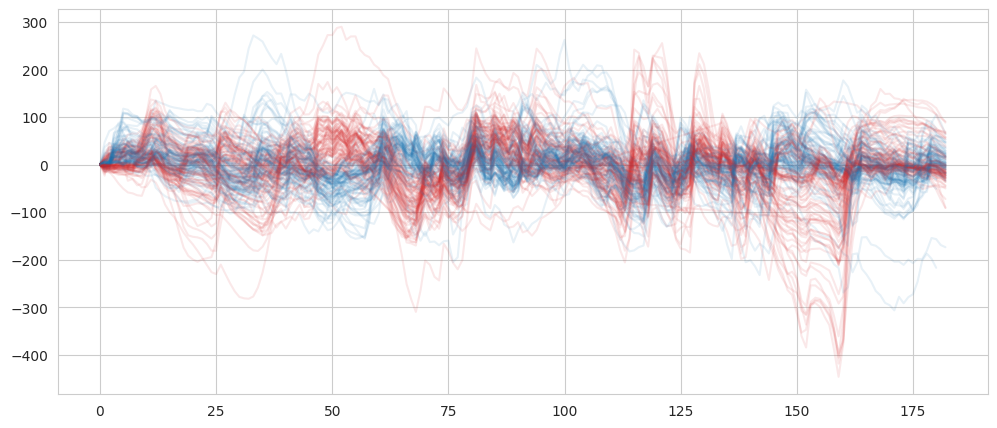

In [155]:
plt.figure(figsize=(12,5))

for i, tree in enumerate(dendro.dendroNr.unique()):
    #plt.scatter(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth, c = f"C{1 if '2012' in tree else 2}", alpha=.1)
    plt.plot(dendro[dendro.dendroNr.eq(tree)].DOY, dendro[dendro.dendroNr.eq(tree)].deltagrowth,
             c = f"C{0 if '2012' in tree else 3}", alpha=.1)

plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


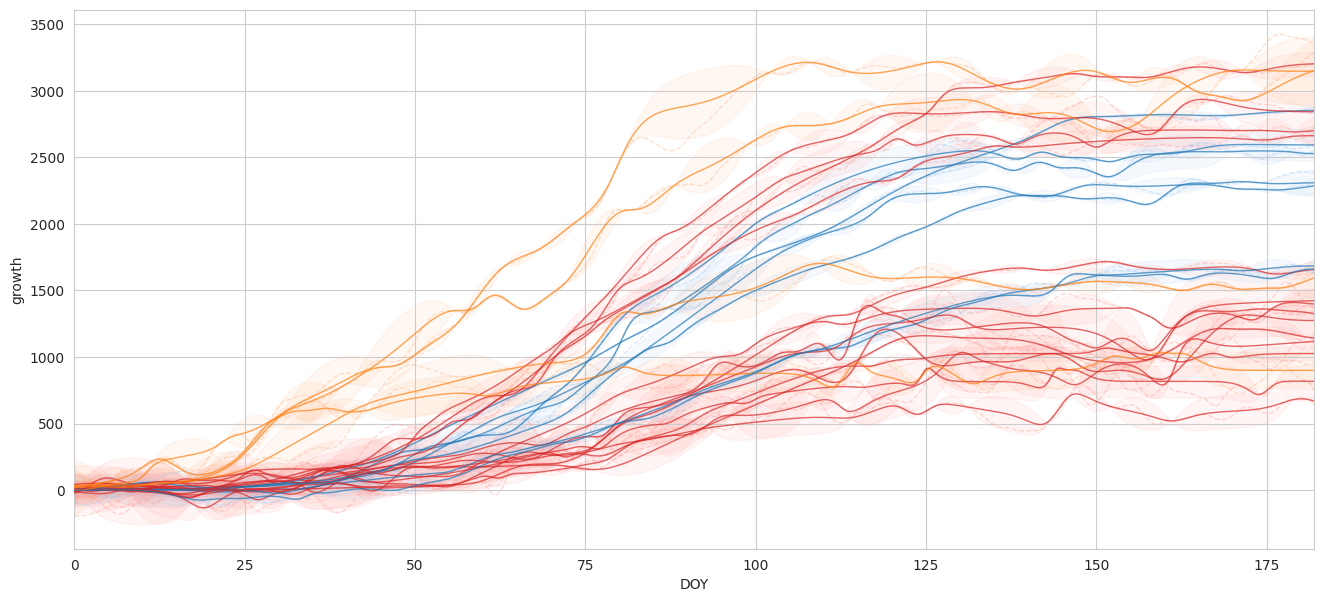

In [168]:
#tree = 'SH_076_2013'

plt.figure(figsize=(16, 7))

rng = np.random.default_rng()

X_test = np.linspace(0, dendro.DOY.max(), 500).reshape(-1, 1)

c = lambda s : 0 if s == "Beech" else (3 if s == "Sycamore" else 1)

for tree in tqdm(dendro.dendroNr.unique()[:25]):
    df_ = dendro.loc[dendro.dendroNr.eq(tree)]

    idx_train = np.sort(rng.integers(0, len(df_.DOY) - 1, 30))

    X_train = df_.DOY.iloc[idx_train].array.reshape(-1, 1)
    y_train = df_.deltagrowth.iloc[idx_train]

    kernel_ = 37**2 * Matern(length_scale=3, length_scale_bounds=(2,16), nu = 2.5) + WhiteKernel(noise_level=.01, noise_level_bounds="fixed")# + ConstantKernel(2**2) * ExpSineSquared(0.00161, 10)
    gp_model = gaussian_process.GaussianProcessRegressor(
        kernel=kernel_,
        #n_restarts_optimizer=2,
        #normalize_y=True,
        #optimizer=None
    )

    gp_model.fit(X_train, y_train)
    mean_pred, std_pred = gp_model.predict(X_test, True)
    y_samples = gp_model.sample_y(X_test, 1)

    weibull_pred = weibull_params[tree][0] * weibull_F(X_test.ravel(), *weibull_params[tree][1:3])

    plt.plot(X_test, mean_pred + weibull_pred, lw=1, zorder=10, alpha = .7, c=sns.color_palette()[c(df_.species.iloc[0])])

    #plt.plot(df_.DOY, df_.growth, lw=1, zorder=10, alpha = .5, c=sns.color_palette("pastel")[c(df_.species.iloc[0])])

    plt.fill_between(
        X_test.ravel(),
        mean_pred + weibull_pred - 1.96 * std_pred,
        mean_pred + weibull_pred + 1.96 * std_pred,
        alpha=.1, zorder=0, color=sns.color_palette("pastel")[c(df_.species.iloc[0])]
    )

    for idx, single_prior in enumerate(y_samples.T):
        plt.plot(
            X_test, single_prior + weibull_pred
            , alpha=.4, lw=1, linestyle="dashed", c=sns.color_palette("pastel")[c(df_.species.iloc[0])]
        )

plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro.DOY.max())
plt.show()